In [87]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch import nn

In [88]:
from sklearn.datasets import make_circles
X,y = make_circles(1000,noise=0.03,random_state=4)

In [89]:
X[:,0]

array([-6.31471241e-01,  4.52014431e-01, -8.03371845e-01, -6.76508388e-01,
        8.17466575e-01, -5.10568832e-01,  6.67721181e-01,  7.82837142e-01,
       -5.62928699e-01, -3.29389564e-01,  8.05331265e-01,  1.23398133e-01,
        6.68646747e-02, -9.51351786e-01, -5.58764202e-01,  3.85550402e-01,
        6.77491287e-01, -1.44455428e-01, -8.17902863e-01, -5.91666887e-01,
       -7.31363758e-01, -7.90927585e-01, -9.95200697e-01,  6.78350011e-01,
        4.60251448e-01, -3.72875966e-01,  4.83785241e-02, -3.20220945e-01,
       -2.01845305e-03,  2.53334362e-01,  3.51620255e-01,  6.72228225e-01,
       -7.71397784e-01, -2.28269928e-01, -6.00487437e-01,  8.95543189e-01,
        7.85495185e-01, -2.02372921e-01, -9.97721534e-01,  6.54100265e-01,
       -7.79486957e-01,  8.55167919e-01, -9.74255939e-01,  6.44446269e-01,
        3.55320949e-01, -3.77179593e-01,  8.06398898e-01,  9.25626342e-01,
        3.95939149e-01, -6.10873653e-01,  5.89088192e-01, -1.75122904e-01,
       -5.14312615e-01,  

In [90]:
circles = pd.DataFrame({"X1": X[:,0],"X2":X[:,1],"label":y})
circles.head(10)

,X1,X2,label
0,-0.631471,0.474847,1
1,0.452014,0.669553,1
2,-0.803372,-0.154012,1
3,-0.676508,-0.414499,1
4,0.817467,0.245586,1
5,-0.510569,-0.598243,1
6,0.667721,-0.362813,1
7,0.782837,-0.016418,1
8,-0.562929,-0.576773,1
9,-0.329390,0.991166,0


In [91]:
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

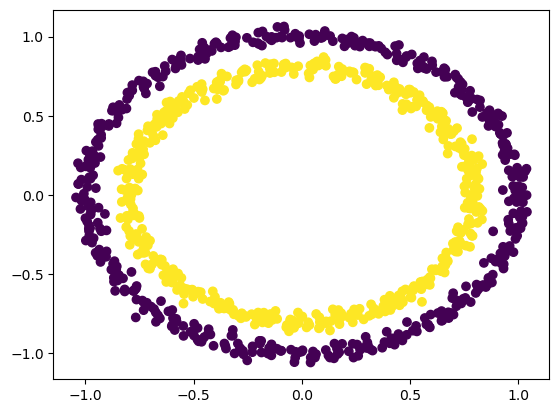

In [92]:
plt.scatter(circles.X1,circles.X2,c=y)

move data into tensors

In [93]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5],y[:5]

(tensor([[-0.6315,  0.4748],
         [ 0.4520,  0.6696],
         [-0.8034, -0.1540],
         [-0.6765, -0.4145],
         [ 0.8175,  0.2456]]),
 tensor([1., 1., 1., 1., 1.]))

In [94]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [95]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [96]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2,5)
        self.layer_2 = nn.Linear(5,1)

    def forward(self,x):
        return self.layer_2(self.layer_1(x))
moedel_0 = CircleModelV0().to(device)
moedel_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [97]:
moedel_0 = nn.Sequential(
    nn.Linear(2,5),
    nn.Linear(5,1)
).to(device)
moedel_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [98]:
moedel_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0062,  0.3905],
                      [-0.1899,  0.3889],
                      [ 0.1278, -0.5164],
                      [-0.2877,  0.3223],
                      [ 0.0208,  0.6217]])),
             ('0.bias', tensor([ 0.1125,  0.2564,  0.5985, -0.1970, -0.2806])),
             ('1.weight',
              tensor([[ 0.4165,  0.2265, -0.1837, -0.0955,  0.4140]])),
             ('1.bias', tensor([-0.2769]))])

In [99]:
with torch.inference_mode():
    untrained_preds = moedel_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-1.],
        [-1.],
        [ 0.],
        [ 0.],
        [ 0.],
        [-1.],
        [-1.],
        [-0.],
        [ 0.],
        [-1.]])

First 10 labels:
tensor([0., 1., 1., 1., 0., 1., 0., 1., 1., 1.])


In [100]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=moedel_0.parameters(),lr=0.1)

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc


In [101]:
moedel_0.eval()
with torch.inference_mode():
    y_logits = moedel_0(X_test.to(device))[:5]
y_logits

tensor([[-0.8540],
        [-0.6282],
        [ 0.0438],
        [ 0.0685],
        [ 0.0571]])

In [102]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.2986],
        [0.3479],
        [0.5109],
        [0.5171],
        [0.5143]])

In [103]:
y_preds = torch.round(y_pred_probs)

In [104]:
y_preds.squeeze()

tensor([0., 0., 1., 1., 1.])

building training and testing loop

In [105]:
epochs = 100
X_train, y_train = X_train.to(device),y_train.to(device)
X_test, y_test =  X_test.to(device),y_test.to(device)

for epoch in range(epochs):
    moedel_0.train()
    # forward
    y_logits = moedel_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_train,y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    moedel_0.eval()
    with torch.inference_mode():
        test_logits = moedel_0(X_test).squeeze()
        test_preds = torch.round(test_logits)
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_preds)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.72306, Acc: 45.88% | Test loss: 0.74159, Test acc: 27.50%
Epoch: 10 | Loss: 0.70841, Acc: 48.12% | Test loss: 0.72155, Test acc: 33.00%
Epoch: 20 | Loss: 0.70209, Acc: 48.38% | Test loss: 0.71172, Test acc: 41.50%
Epoch: 30 | Loss: 0.69905, Acc: 49.25% | Test loss: 0.70637, Test acc: 48.00%
Epoch: 40 | Loss: 0.69739, Acc: 49.75% | Test loss: 0.70317, Test acc: 48.00%
Epoch: 50 | Loss: 0.69637, Acc: 49.75% | Test loss: 0.70109, Test acc: 48.00%
Epoch: 60 | Loss: 0.69568, Acc: 49.88% | Test loss: 0.69965, Test acc: 48.00%
Epoch: 70 | Loss: 0.69518, Acc: 50.00% | Test loss: 0.69861, Test acc: 48.00%
Epoch: 80 | Loss: 0.69480, Acc: 49.62% | Test loss: 0.69782, Test acc: 48.00%
Epoch: 90 | Loss: 0.69450, Acc: 49.88% | Test loss: 0.69720, Test acc: 48.00%


In [106]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


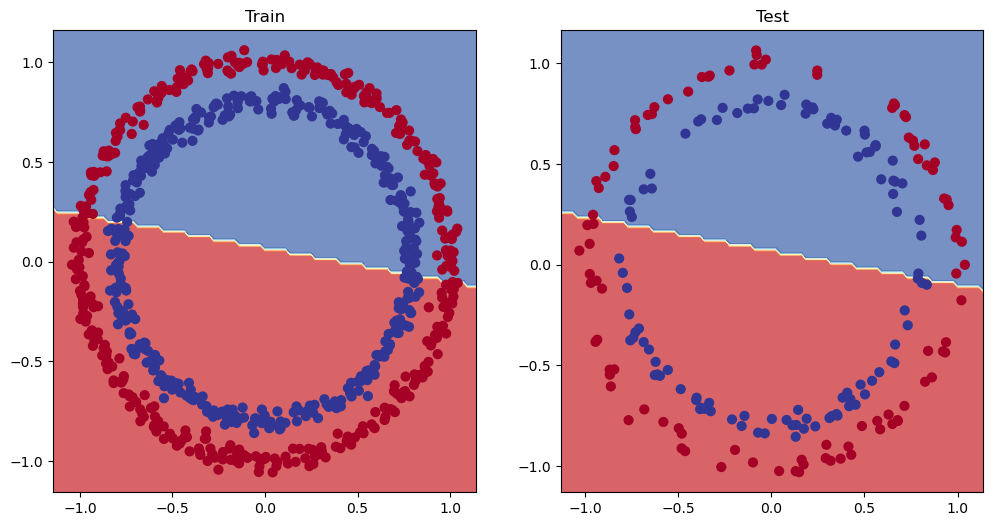

In [107]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(moedel_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(moedel_0, X_test, y_test)

In [108]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2,10)
        self.layer_2 = nn.Linear(10,10)
        self.layer_3 = nn.Linear(10,1)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [109]:
model_3(torch.Tensor([[2,3],[2,4]]))

tensor([[-0.3889],
        [-0.4020]], grad_fn=<AddmmBackward0>)

In [110]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),lr=0.1)

In [111]:
len(X_test), len(y_test)

(200, 200)

In [112]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs  = 10000
for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits,y_train)
    acc = accuracy_fn(y_train, y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_test,test_preds)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.7005, Acc: 48.38% | Test Loss: 0.7075, Test Acc: 45.50%
Epoch: 100 | Loss: 0.6939, Acc: 49.62% | Test Loss: 0.6974, Test Acc: 45.00%
Epoch: 200 | Loss: 0.6885, Acc: 53.25% | Test Loss: 0.6924, Test Acc: 47.50%
Epoch: 300 | Loss: 0.6829, Acc: 55.50% | Test Loss: 0.6878, Test Acc: 46.50%
Epoch: 400 | Loss: 0.6741, Acc: 57.88% | Test Loss: 0.6806, Test Acc: 51.00%
Epoch: 500 | Loss: 0.6590, Acc: 64.50% | Test Loss: 0.6682, Test Acc: 61.50%
Epoch: 600 | Loss: 0.6312, Acc: 75.12% | Test Loss: 0.6434, Test Acc: 69.50%
Epoch: 700 | Loss: 0.5756, Acc: 92.50% | Test Loss: 0.5886, Test Acc: 89.50%
Epoch: 800 | Loss: 0.4704, Acc: 97.75% | Test Loss: 0.4840, Test Acc: 99.00%
Epoch: 900 | Loss: 0.3232, Acc: 99.25% | Test Loss: 0.3349, Test Acc: 100.00%
Epoch: 1000 | Loss: 0.4831, Acc: 66.12% | Test Loss: 0.4428, Test Acc: 67.00%
Epoch: 1100 | Loss: 0.4379, Acc: 71.38% | Test Loss: 0.4473, Test Acc: 71.00%
Epoch: 1200 | Loss: 0.0961, Acc: 100.00% | Test Loss: 0.0990, Test Acc: 100

In [113]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([0., 1., 1., 1., 0., 1., 0., 1., 1., 1.]),
 tensor([0., 1., 1., 1., 0., 1., 0., 1., 1., 1.]))

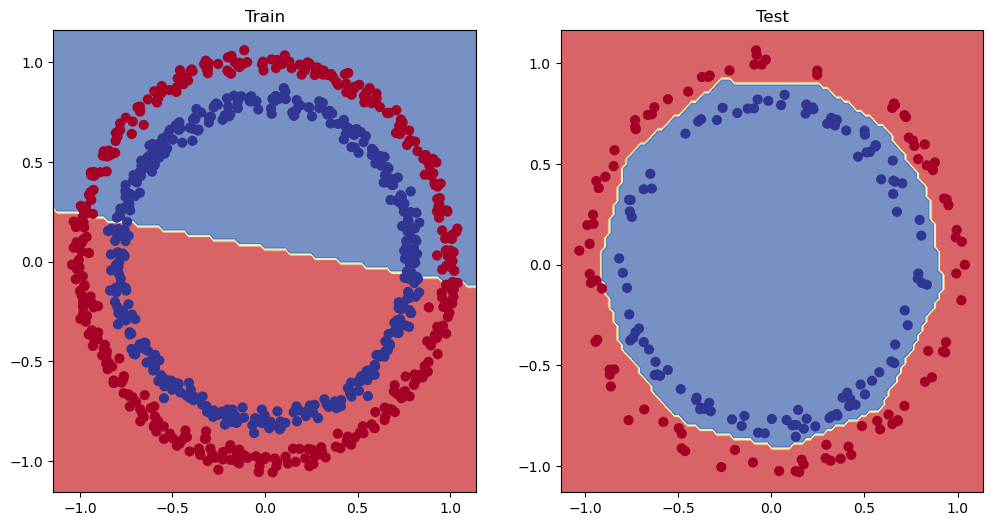

In [114]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(moedel_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

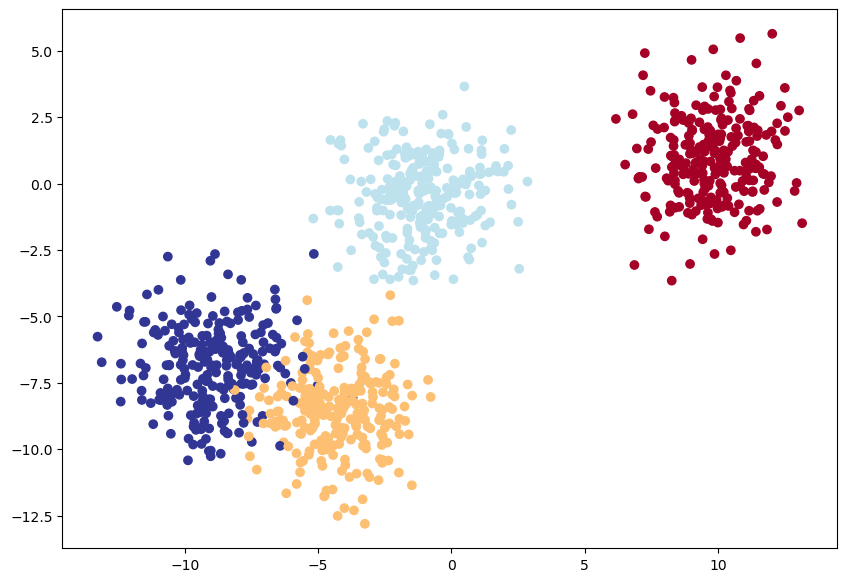

In [115]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
x_blob, y_blob = make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES,cluster_std=1.5,random_state=45)

x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob,y_blob,test_size=0.2,random_state=42)
plt.figure(figsize=(10, 7))
plt.scatter(x_blob[:, 0], x_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [116]:
class BlobModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(2,8),
            nn.Linear(8,8),
            nn.Linear(8,4)
        )
    def forward(self,x):
        return self.linear_layer_stack(x)

model_4 = BlobModel().to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [117]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),lr=0.1)

In [118]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[ 0.5536,  0.7720,  0.5061,  0.6829],
        [-4.0939, -0.8343, -1.7786, -2.1826],
        [ 2.1133,  0.9549,  1.2005,  1.6603],
        [-3.9899, -0.9247, -1.7532, -2.1129],
        [ 0.9267,  0.9533,  0.7002,  0.9107],
        [-1.1606, -0.3424, -0.4427, -0.3509],
        [ 1.1461,  0.8170,  0.7649,  1.0553],
        [-3.8843, -0.8766, -1.6989, -2.0482],
        [-4.6599, -1.0257, -2.0560, -2.5317],
        [ 0.5149,  0.7003,  0.4753,  0.6616]])

In [119]:
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs[:5]

tensor([[0.2306, 0.2869, 0.2199, 0.2625],
        [0.0228, 0.5928, 0.2305, 0.1539],
        [0.4253, 0.1336, 0.1707, 0.2704],
        [0.0261, 0.5592, 0.2442, 0.1704],
        [0.2626, 0.2697, 0.2094, 0.2584]])

In [120]:
y_preds = torch.argmax(y_pred_probs,dim=1)

In [121]:
torch.eq(y_preds,y_test).sum()/len(y_preds)

tensor(0.4050)

In [122]:
y_blob_train[:3]

tensor([3, 2, 0])

In [123]:
epochs = 100
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1),dim=1)
    loss = loss_fn(y_logits,y_blob_train)
    acc = accuracy_fn(y_blob_train,y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.argmax(torch.softmax(test_logits,dim=1),dim=1)
        test_loss = loss_fn(test_logits,y_blob_test)
        test_acc = accuracy_fn(y_blob_test,test_preds)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.2041, Acc: 39.50% | Test loss: 1.0039, Test acc: 52.50%
Epoch: 10 | Loss: 0.5912, Acc: 71.62% | Test loss: 0.5369, Test acc: 72.50%
Epoch: 20 | Loss: 0.4068, Acc: 87.50% | Test loss: 0.3353, Test acc: 88.00%
Epoch: 30 | Loss: 0.3247, Acc: 90.50% | Test loss: 0.2529, Test acc: 91.00%
Epoch: 40 | Loss: 0.2822, Acc: 91.88% | Test loss: 0.2170, Test acc: 93.00%
Epoch: 50 | Loss: 0.2599, Acc: 91.88% | Test loss: 0.2060, Test acc: 93.50%
Epoch: 60 | Loss: 0.2385, Acc: 92.62% | Test loss: 0.1878, Test acc: 94.00%
Epoch: 70 | Loss: 0.2089, Acc: 93.75% | Test loss: 0.1566, Test acc: 94.50%
Epoch: 80 | Loss: 0.1891, Acc: 94.38% | Test loss: 0.1400, Test acc: 95.50%
Epoch: 90 | Loss: 0.1784, Acc: 94.25% | Test loss: 0.1351, Test acc: 95.50%


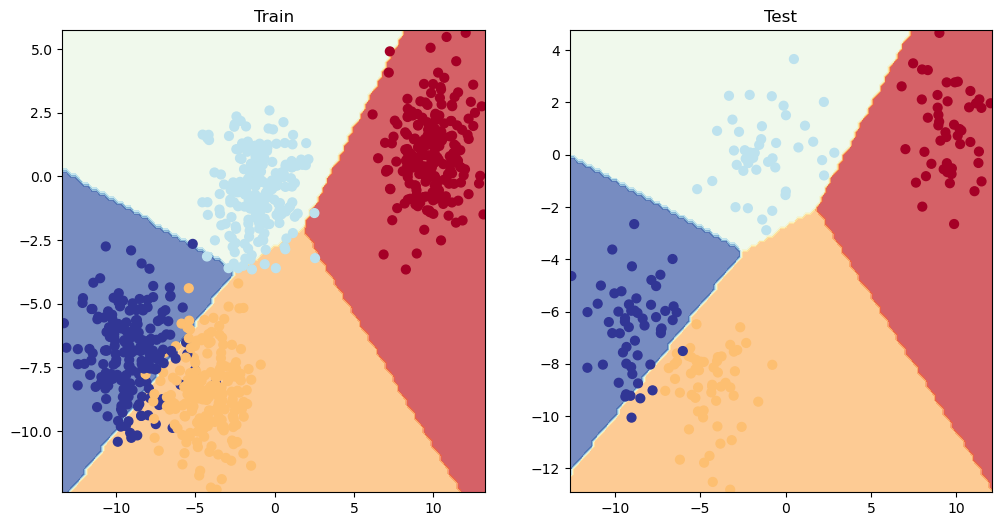

In [124]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [125]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy().to(device)

# Calculuate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'